In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
# data analysis and wrangling
import pandas as pd
import numpy as np
import random as rnd

# visualization
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
train_df = pd.read_csv('../input/titanic/train.csv')
test_df = pd.read_csv('../input/titanic/test.csv')

In [4]:
pass_id = test_df['PassengerId']

# Invastigate the Data

In [5]:
print(train_df.info())
print('---------------')
print(test_df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB
None
---------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    

- Age, Cabin, Fare have nulls in test 
- Age, Cabin, Embarked have nulls in train


In [6]:
#checking nan values percentage
total = train_df.isnull().sum().sort_values(ascending=False)
percent = (train_df.isnull().sum()/train_df.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
Cabin,687,0.771044
Age,177,0.198653
Embarked,2,0.002245
PassengerId,0,0.000000
Survived,0,0.000000
Pclass,0,0.000000
Name,0,0.000000
Sex,0,0.000000
SibSp,0,0.000000
Parch,0,0.000000


# Is the ticket related to class or sibiling 

In [7]:
train_df['Ticket'].value_counts()

347082      7
CA. 2343    7
1601        7
3101295     6
CA 2144     6
           ..
9234        1
19988       1
2693        1
PC 17612    1
370376      1
Name: Ticket, Length: 681, dtype: int64

In [8]:
train_df[train_df['Ticket'] == '347082']

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
13,14,0,3,"Andersson, Mr. Anders Johan",male,39.0,1,5,347082,31.275,NaN,S
119,120,0,3,"Andersson, Miss. Ellis Anna Maria",female,2.0,4,2,347082,31.275,NaN,S
541,542,0,3,"Andersson, Miss. Ingeborg Constanzia",female,9.0,4,2,347082,31.275,NaN,S
542,543,0,3,"Andersson, Miss. Sigrid Elisabeth",female,11.0,4,2,347082,31.275,NaN,S
610,611,0,3,"Andersson, Mrs. Anders Johan (Alfrida Konstant...",female,39.0,1,5,347082,31.275,NaN,S
813,814,0,3,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4,2,347082,31.275,NaN,S
850,851,0,3,"Andersson, Master. Sigvard Harald Elias",male,4.0,4,2,347082,31.275,NaN,S


# from the name we can figure that every family have the same ticket number 
# and most likely will have same cabin and this could help us fill the cabin feature

In [9]:
train_df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


- 38 % survived 
- most of passengers are youth (30 years old)


In [10]:
train_df.describe(include=['O'])

,Name,Sex,Ticket,Cabin,Embarked
count,891,891,891,204,889
unique,891,2,681,147,3
top,"Braund, Mr. Owen Harris",male,347082,B96 B98,S
freq,1,577,7,4,644


In [11]:
male_perc = 577/891
male_perc

0.6475869809203143

- So male are 64% of the passengers
- it seems that Cabin have duplicates, indicates that every family stay in the same cabin 
- also Ticket have duplicates as we see that family have same Ticket number 

I want to know how well does each feature correlate with Survival. We want to do this early in our project and match these quick correlations with modelled correlations later in the project.

We may also add to our assumptions based on the problem description noted earlier.

- Women (Sex=female) were more likely to have survived.
- Children (Age<2) were more likely to have survived.
- The upper-class passengers (Pclass=1) were more likely to have survived.

In [12]:
# I'll make sure of the competition assumption
train_df[['Sex', 'Survived']].groupby(['Sex'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Sex,Survived
0,female,0.742038
1,male,0.188908


In [13]:
# I'll make sure of the competition assumption
train_df[['Pclass', 'Survived']].groupby(['Pclass'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Pclass,Survived
0,1,0.629630
1,2,0.472826
2,3,0.242363


In [14]:
# I'll make sure of the competition assumption
train_df[['SibSp', 'Survived']].groupby(['SibSp'], as_index=False).mean().sort_values(by='Survived', ascending=False)
# Logically, the more you have a siblings the less probabilty of surviving  

,SibSp,Survived
1,1,0.535885
2,2,0.464286
0,0,0.345395
3,3,0.250000
4,4,0.166667
5,5,0.000000
6,8,0.000000


In [15]:
# I'll make sure of the competition assumption
train_df[['Parch', 'Survived']].groupby(['Parch'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Parch,Survived
3,3,0.600000
1,1,0.550847
2,2,0.500000
0,0,0.343658
5,5,0.200000
4,4,0.000000
6,6,0.000000


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Age', ylabel='Density'>

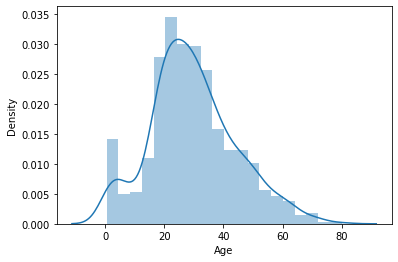

In [16]:
sns.distplot(train_df['Age'])

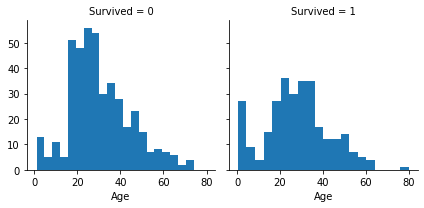

In [17]:
g = sns.FacetGrid(train_df, col='Survived')
g.map(plt.hist, 'Age', bins=20)

# Children less than 2 years old have higher survival rate more than anyone

- I want to see if the fare related to survival rate 


In [18]:
corr = train_df.select_dtypes(exclude=['object']).corr()
abs(corr['Survived']).sort_values(ascending=False)

Survived       1.000000
Pclass         0.338481
Fare           0.257307
Parch          0.081629
Age            0.077221
SibSp          0.035322
PassengerId    0.005007
Name: Survived, dtype: float64

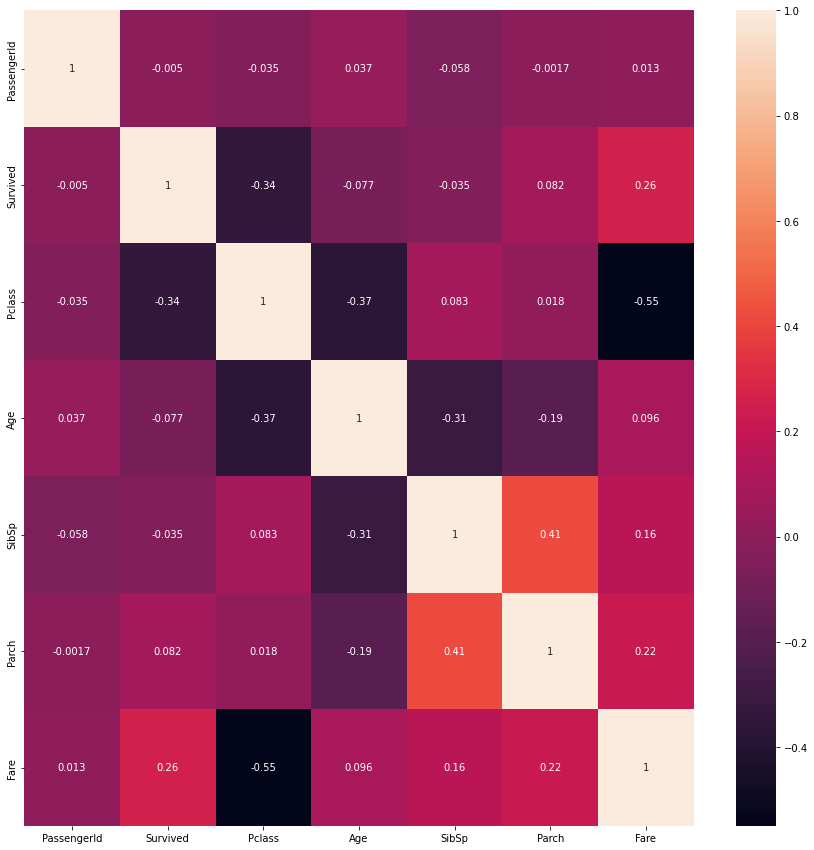

In [19]:
plt.figure(figsize=(15,15))
sns.heatmap(corr, annot = True)
plt.show()

# So there's no correlation between numerical variables -- and the most correlated feature with survival were the Pclass

# Let's Invastigate the Categorical features


- I want to figure out wether specific embarked have specific class or all embarked ar equal 

<AxesSubplot:xlabel='Embarked'>

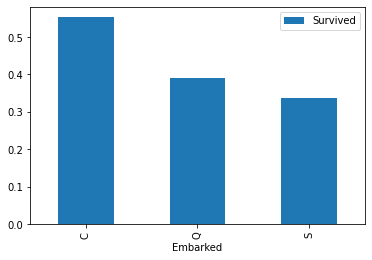

In [20]:
train_df[['Embarked', 'Survived']].groupby(['Embarked'], as_index=True).mean().sort_values(by='Survived', ascending=False).plot(kind='bar')

<BarContainer object of 891 artists>

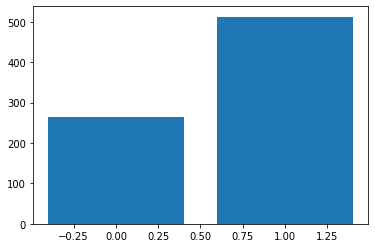

In [21]:
plt.bar(data = train_df, height = 'Fare',x = 'Survived')

# Observations.

- Higher fare paying passengers had better survival. 
- Embarked C have higher survival rate which maybe contain more from Class 1

# Now I want to complete, drop, engineer my data based on the EDA

In [22]:
train_df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# I'll drop PassengerId and Cabin and Ticket featuers as i belive that it'll not help

In [23]:
train_dff = train_df.drop(columns = ['Cabin', 'Ticket', 'PassengerId']) 
test_dff = test_df.drop(columns = ['Cabin', 'Ticket', 'PassengerId']) 

In [24]:
train_dff['Sex'] = train_dff['Sex'].replace({'female':1,'male':0})
test_dff['Sex'] = test_dff['Sex'].replace({'female':1,'male':0})

In [25]:
train_dff[train_dff['Age'] < 16]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
7,0,3,"Palsson, Master. Gosta Leonard",0,2.00,3,1,21.0750,S
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",1,14.00,1,0,30.0708,C
10,1,3,"Sandstrom, Miss. Marguerite Rut",1,4.00,1,1,16.7000,S
14,0,3,"Vestrom, Miss. Hulda Amanda Adolfina",1,14.00,0,0,7.8542,S
16,0,3,"Rice, Master. Eugene",0,2.00,4,1,29.1250,Q
...,...,...,...,...,...,...,...,...,...
831,1,2,"Richards, Master. George Sibley",0,0.83,1,1,18.7500,S
850,0,3,"Andersson, Master. Sigvard Harald Elias",0,4.00,4,2,31.2750,S
852,0,3,"Boulos, Miss. Nourelain",1,9.00,1,1,15.2458,C
869,1,3,"Johnson, Master. Harold Theodor",0,4.00,1,1,11.1333,S


In [26]:
combine = [train_dff, test_dff]

In [27]:
train_dff[train_dff['Age'].isnull()]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
5,0,3,"Moran, Mr. James",0,NaN,0,0,8.4583,Q
17,1,2,"Williams, Mr. Charles Eugene",0,NaN,0,0,13.0000,S
19,1,3,"Masselmani, Mrs. Fatima",1,NaN,0,0,7.2250,C
26,0,3,"Emir, Mr. Farred Chehab",0,NaN,0,0,7.2250,C
28,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",1,NaN,0,0,7.8792,Q
...,...,...,...,...,...,...,...,...,...
859,0,3,"Razi, Mr. Raihed",0,NaN,0,0,7.2292,C
863,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",1,NaN,8,2,69.5500,S
868,0,3,"van Melkebeke, Mr. Philemon",0,NaN,0,0,9.5000,S
878,0,3,"Laleff, Mr. Kristo",0,NaN,0,0,7.8958,S


In [28]:
nulls = train_dff[train_dff['Age'].isnull()]
nulls2 = test_dff[test_dff['Age'].isnull()]
nulls = list(nulls['Name'])
nulls2 = list(nulls2['Name'])

In [29]:
# Fill Age in train data with 2 several random ratios, if the person survived it will get age from 22 to 36 
# and if he survived he will get age from 37 to 60
for i, c in enumerate(train_dff['Survived']):
    if train_dff.loc[i,'Name'] in nulls: 
        if c == 0:
            train_dff.loc[i,'Age'] =  np.random.randint(22, 36) # Youth
        else:
            train_dff.loc[i,'Age'] =  np.random.randint(37, 60) # Elder

In [30]:
for i, c in enumerate(test_dff['Name']):
    if c in nulls2:
        test_dff.loc[i,'Age'] =  np.random.randint(16, 50)

In [31]:
print(train_dff.Age.isnull().sum())
print(test_dff.Age.isnull().sum())

0
0


# let's create Age bands then convert age feature to [0, 1, 2, 3, 4]

In [32]:
# This code isn't important i was just practice how may i make bands when i need 

train_dff['AgeBand'] = pd.cut(train_dff['Age'], 5)
train_dff[['AgeBand', 'Survived']].groupby(['AgeBand'], as_index=False).mean().sort_values(by='AgeBand', ascending=True)


,AgeBand,Survived
0,"(0.34, 16.336]",0.550000
1,"(16.336, 32.252]",0.288288
2,"(32.252, 48.168]",0.430328
3,"(48.168, 64.084]",0.576087
4,"(64.084, 80.0]",0.090909


In [33]:
train_dff[train_dff['Age'] < 16]

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,AgeBand
7,0,3,"Palsson, Master. Gosta Leonard",0,2.00,3,1,21.0750,S,"(0.34, 16.336]"
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",1,14.00,1,0,30.0708,C,"(0.34, 16.336]"
10,1,3,"Sandstrom, Miss. Marguerite Rut",1,4.00,1,1,16.7000,S,"(0.34, 16.336]"
14,0,3,"Vestrom, Miss. Hulda Amanda Adolfina",1,14.00,0,0,7.8542,S,"(0.34, 16.336]"
16,0,3,"Rice, Master. Eugene",0,2.00,4,1,29.1250,Q,"(0.34, 16.336]"
...,...,...,...,...,...,...,...,...,...,...
831,1,2,"Richards, Master. George Sibley",0,0.83,1,1,18.7500,S,"(0.34, 16.336]"
850,0,3,"Andersson, Master. Sigvard Harald Elias",0,4.00,4,2,31.2750,S,"(0.34, 16.336]"
852,0,3,"Boulos, Miss. Nourelain",1,9.00,1,1,15.2458,C,"(0.34, 16.336]"
869,1,3,"Johnson, Master. Harold Theodor",0,4.00,1,1,11.1333,S,"(0.34, 16.336]"


In [34]:
for dataset in combine:    
    dataset.loc[ dataset['Age'] <= 16, 'Age'] = 0
    dataset.loc[(dataset['Age'] > 16) & (dataset['Age'] <= 32), 'Age'] = 1
    dataset.loc[(dataset['Age'] > 32) & (dataset['Age'] <= 48), 'Age'] = 2
    dataset.loc[(dataset['Age'] > 48) & (dataset['Age'] <= 64), 'Age'] = 3
    dataset.loc[ dataset['Age'] > 64, 'Age'] = 4
train_dff.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked,AgeBand
0,0,3,"Braund, Mr. Owen Harris",0,1.0,1,0,7.2500,S,"(16.336, 32.252]"
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,2.0,1,0,71.2833,C,"(32.252, 48.168]"
2,1,3,"Heikkinen, Miss. Laina",1,1.0,0,0,7.9250,S,"(16.336, 32.252]"
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2.0,1,0,53.1000,S,"(32.252, 48.168]"
4,0,3,"Allen, Mr. William Henry",0,2.0,0,0,8.0500,S,"(32.252, 48.168]"


In [35]:
train_dff = train_dff.drop(['AgeBand'], axis=1)
combine = [train_dff, test_dff]
train_dff.head()

,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Fare,Embarked
0,0,3,"Braund, Mr. Owen Harris",0,1.0,1,0,7.2500,S
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,2.0,1,0,71.2833,C
2,1,3,"Heikkinen, Miss. Laina",1,1.0,0,0,7.9250,S
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2.0,1,0,53.1000,S
4,0,3,"Allen, Mr. William Henry",0,2.0,0,0,8.0500,S


In [36]:
train_dff['Age'].unique()
test_dff['Age'].unique()

array([2., 3., 1., 0., 4.])

# I'll create family feature which is combination between sibling and parch

In [37]:
for dataset in combine:
    dataset['Family'] = dataset['SibSp'] + dataset['Parch'] 

In [38]:
train_dff[['Family', 'Survived']].groupby(['Family'], as_index=False).mean().sort_values(by='Survived', ascending=False)

,Family,Survived
3,3,0.724138
2,2,0.578431
1,1,0.552795
6,6,0.333333
0,0,0.303538
4,4,0.200000
5,5,0.136364
7,7,0.000000
8,10,0.000000


In [39]:
train_df = train_dff.drop(['Parch', 'SibSp'], axis=1)
test_df = test_dff.drop(['Parch', 'SibSp'], axis=1)
combine = [train_df, test_df]

train_df.head()

,Survived,Pclass,Name,Sex,Age,Fare,Embarked,Family
0,0,3,"Braund, Mr. Owen Harris",0,1.0,7.2500,S,1
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,2.0,71.2833,C,1
2,1,3,"Heikkinen, Miss. Laina",1,1.0,7.9250,S,0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2.0,53.1000,S,1
4,0,3,"Allen, Mr. William Henry",0,2.0,8.0500,S,0


# I'll make a flag feature return 1 if the passenger is alone

In [40]:
for dataset in combine:
    dataset['Alone'] = 0
    dataset.loc[train_df['Family'] == 0,'Alone'] = 1

In [41]:
train_df['Embarked'].isnull().sum()

2

In [42]:
train_df['Embarked'] = train_df['Embarked'].fillna(train_df['Embarked'].mode()[0])

In [43]:
test_df['Fare'].fillna(test_df['Fare'].dropna().median(), inplace=True)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='Fare', ylabel='Density'>

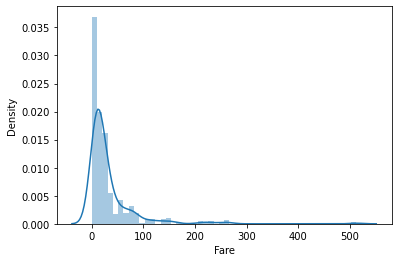

In [44]:
sns.distplot(train_df['Fare'])

In [45]:
for dataset in combine:
    dataset['Age*Class'] = dataset.Age * dataset.Pclass

train_df.loc[:, ['Age*Class', 'Age', 'Pclass']].head(10)

,Age*Class,Age,Pclass
0,3.0,1.0,3
1,2.0,2.0,1
2,3.0,1.0,3
3,2.0,2.0,1
4,6.0,2.0,3
5,3.0,1.0,3
6,3.0,3.0,1
7,0.0,0.0,3
8,3.0,1.0,3
9,0.0,0.0,2


# I may convert it to intervals also because a lot of people pay in a range 0 to 150 

In [46]:
for dataset in combine:
    dataset.loc[ dataset['Fare'] <= 7.91, 'Fare'] = 0
    dataset.loc[(dataset['Fare'] > 7.91) & (dataset['Fare'] <= 14.454), 'Fare'] = 1
    dataset.loc[(dataset['Fare'] > 14.454) & (dataset['Fare'] <= 31), 'Fare']   = 2
    dataset.loc[ dataset['Fare'] > 31, 'Fare'] = 3
    dataset['Fare'] = dataset['Fare'].astype(int)

combine = [train_df, test_df]
    
train_df.head(10)

,Survived,Pclass,Name,Sex,Age,Fare,Embarked,Family,Alone,Age*Class
0,0,3,"Braund, Mr. Owen Harris",0,1.0,0,S,1,0,3.0
1,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",1,2.0,3,C,1,0,2.0
2,1,3,"Heikkinen, Miss. Laina",1,1.0,1,S,0,1,3.0
3,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",1,2.0,3,S,1,0,2.0
4,0,3,"Allen, Mr. William Henry",0,2.0,1,S,0,1,6.0
5,0,3,"Moran, Mr. James",0,1.0,1,Q,0,1,3.0
6,0,1,"McCarthy, Mr. Timothy J",0,3.0,3,S,0,1,3.0
7,0,3,"Palsson, Master. Gosta Leonard",0,0.0,2,S,4,0,0.0
8,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",1,1.0,1,S,2,0,3.0
9,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",1,0.0,2,C,1,0,0.0


In [47]:
for dataset in combine:
    dataset['Embarked'] = dataset['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(int)

In [48]:
train_df = train_df.drop('Name', axis = 1)
test_df = test_df.drop('Name', axis = 1)

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, LabelEncoder
from sklearn.model_selection import GridSearchCV

In [50]:
X = train_df.drop('Survived', axis =1)
y = train_df['Survived']
print(X.shape, test_df.shape)

(891, 8) (418, 8)


In [51]:
X.head()

,Pclass,Sex,Age,Fare,Embarked,Family,Alone,Age*Class
0,3,0,1.0,0,0,1,0,3.0
1,1,1,2.0,3,1,1,0,2.0
2,3,1,1.0,1,0,0,1,3.0
3,1,1,2.0,3,0,1,0,2.0
4,3,0,2.0,1,0,0,1,6.0


In [52]:
'''X['Fare'] = np.log(X['Fare'])
test_df['Fare'] = np.log(test_df['Fare'])'''

"X['Fare'] = np.log(X['Fare'])\ntest_df['Fare'] = np.log(test_df['Fare'])"

In [53]:
X.head()

,Pclass,Sex,Age,Fare,Embarked,Family,Alone,Age*Class
0,3,0,1.0,0,0,1,0,3.0
1,1,1,2.0,3,1,1,0,2.0
2,3,1,1.0,1,0,0,1,3.0
3,1,1,2.0,3,0,1,0,2.0
4,3,0,2.0,1,0,0,1,6.0


In [54]:
'''OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)
OH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X[['Embarked']]))

OH_cols_test = pd.DataFrame(OH_encoder.transform(test_df[['Embarked']]))

# One-hot encoding removed index; put it back
OH_cols_train.index = X.index
OH_cols_test.index = test_df.index

# Remove categorical columns (will replace with one-hot encoding)
num_X_train = X.drop('Embarked', axis=1)
num_X_test = test_df.drop('Embarked', axis=1)

# Add one-hot encoded columns to numerical features
OH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)
OH_X_test = pd.concat([num_X_test, OH_cols_test], axis=1)'''

"OH_encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)\nOH_cols_train = pd.DataFrame(OH_encoder.fit_transform(X[['Embarked']]))\n\nOH_cols_test = pd.DataFrame(OH_encoder.transform(test_df[['Embarked']]))\n\n# One-hot encoding removed index; put it back\nOH_cols_train.index = X.index\nOH_cols_test.index = test_df.index\n\n# Remove categorical columns (will replace with one-hot encoding)\nnum_X_train = X.drop('Embarked', axis=1)\nnum_X_test = test_df.drop('Embarked', axis=1)\n\n# Add one-hot encoded columns to numerical features\nOH_X_train = pd.concat([num_X_train, OH_cols_train], axis=1)\nOH_X_test = pd.concat([num_X_test, OH_cols_test], axis=1)"

In [55]:
Skwed_features = ['Fare'] # need log
##cat_features = ['Embarked'] # need encoding

In [56]:
preprocessor = ColumnTransformer([
    ('log_trans', FunctionTransformer(func = np.log1p, validate = False), Skwed_features)#,
    ##('label',OneHotEncoder(), cat_features)
])

In [57]:
'''X = preprocessor.fit_transform(X)
test_df = preprocessor.transform(test_df)'''

'X = preprocessor.fit_transform(X)\ntest_df = preprocessor.transform(test_df)'

In [58]:
model = LogisticRegression()
param_grid = {'penalty' : ['l2', 'elasticnet'],
             'C':[0.1,0.5,0.001,0.005]}
grid_cv = GridSearchCV(model, param_grid, cv=5, scoring = 'accuracy')
grid_cv.fit(X,y)
grid_cv.score(X,y)
Y_pred = grid_cv.predict(test_df)

/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
20 fits failed out of a total of 40.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
20 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 681, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/opt/conda/lib/python3.7/site-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solver

In [59]:
model = KNeighborsClassifier(n_neighbors=5)
param_grid = {'n_neighbors':[3, 4, 5]}
grid_cv = GridSearchCV(model, param_grid, cv=5,  scoring = 'accuracy')
grid_cv.fit(X,y)
grid_cv.score(X,y)

0.8496071829405163

In [60]:
model = RandomForestClassifier()
param_grid = {'n_estimators': [50, 100]}
grid_cv = GridSearchCV(model, param_grid, cv=5,  scoring = 'accuracy')
grid_cv.fit(X,y)
Y_pred2 = grid_cv.predict(test_df)
grid_cv.score(X,y)

0.8810325476992144

In [61]:
'''from tensorflow import keras
from tensorflow.keras import layers

# YOUR CODE HERE: define the model given in the diagram
model = keras.Sequential([
    layers.BatchNormalization(input_shape=[X.shape[1]]),
    layers.Dense(units = 256),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.3),
    layers.Dense(units = 256),
    layers.BatchNormalization(),
    layers.Dropout(rate=0.3),
    layers.Dense(1,activation='sigmoid')
])

model.compile(optimizer = 'adam',
              loss ='binary_crossentropy',
             metrics = ['binary_accuracy'])

early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)

model.fit(
    X, y,
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
)'''

"from tensorflow import keras\nfrom tensorflow.keras import layers\n\n# YOUR CODE HERE: define the model given in the diagram\nmodel = keras.Sequential([\n    layers.BatchNormalization(input_shape=[X.shape[1]]),\n    layers.Dense(units = 256),\n    layers.BatchNormalization(),\n    layers.Dropout(rate=0.3),\n    layers.Dense(units = 256),\n    layers.BatchNormalization(),\n    layers.Dropout(rate=0.3),\n    layers.Dense(1,activation='sigmoid')\n])\n\nmodel.compile(optimizer = 'adam',\n              loss ='binary_crossentropy',\n             metrics = ['binary_accuracy'])\n\nearly_stopping = keras.callbacks.EarlyStopping(\n    patience=5,\n    min_delta=0.001,\n    restore_best_weights=True,\n)\n\nmodel.fit(\n    X, y,\n    batch_size=512,\n    epochs=200,\n    callbacks=[early_stopping],\n)"

In [62]:
#Y_pred = model.predict(test_df)
#Y_pred = np.round(Y_pred.reshape(418,))

In [63]:
Y_pred = Y_pred.astype(int) 

In [64]:
svc = SVC(kernel='rbf')
svc.fit(X, y)
svc.score(X, y)
Y_pred = svc.predict(test_df)

In [65]:
submission = pd.DataFrame({
        "PassengerId": pass_id,
        "Survived": Y_pred
    })
submission.to_csv('submission.csv', index = False)